In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import  matplotlib.pyplot as plt
import numpy as np
from torchmetrics.classification import Accuracy
import warnings
warnings.filterwarnings("ignore")
import torch.nn.functional as F

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),                # convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # normalization
])

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"

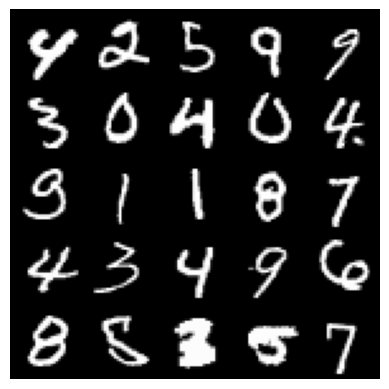

In [22]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:25], normalize=True, padding=1, nrow=5).numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

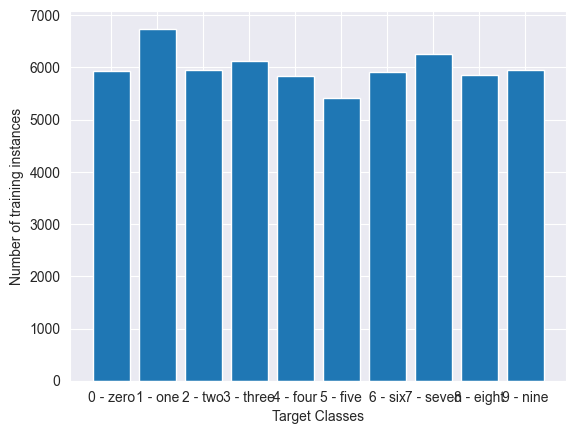

In [23]:
classes = []
for batch_idx, data in enumerate(train_loader):
    x, y = data
    classes.extend(y.tolist())

unique, counts = np.unique(classes, return_counts=True)
names = list(test_dataset.class_to_idx.keys())
plt.bar(names, counts)
plt.xlabel("Target Classes")
plt.ylabel("Number of training instances")
plt.show()

In [5]:
class NN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, 256), nn.Linear(256, 128), nn.Linear(128, 64), nn.Linear(64, output_size)])
        self.relu = nn.ReLU()

    def forward(self, x):
        for i , layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = self.relu(x)
        return x

model = NN(input_size=784, output_size=10)

In [6]:
class NN1(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(input_size, 256), nn.BatchNorm1d(256), nn.ReLU()),
            nn.Sequential(nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU()),
            nn.Sequential(nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU()),
            nn.Linear(64, output_size)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

model1 = NN1(input_size=784, output_size=10)

In [7]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [8]:
def train_val(model, criterion, optimizer, train_loader, test_loader, num_epochs):
    val_loss = []
    train_loss = []

    accuracy = Accuracy(task="multiclass", num_classes=10).to(DEVICE)

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            if isinstance(model, NN):
                X_batch = X_batch.view(X_batch.size(0), -1)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        train_epoch_loss = np.mean(train_losses)
        train_loss.append(train_epoch_loss)


        model.eval()
        acc_val = []
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

                if isinstance(model, NN):
                    X_batch = X_batch.view(X_batch.size(0), -1)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                proba = torch.softmax(outputs, dim = 1)
                batch_accuracy = accuracy(proba, y_batch)
                acc_val.append(batch_accuracy.item())

                val_losses.append(loss.item())

        val_epoch_loss = np.mean(val_losses)
        val_loss.append(val_epoch_loss)

        print(f'Epoch {epoch+1}, Train Loss: {train_epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')

        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    early_stopping.load_best_model(model)
    return train_loss, val_loss, acc_val

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, delta=0.01)

In [10]:
train_loss, val_loss, acc_val = train_val(model, criterion, optimizer, train_loader, test_loader, 10)

Epoch 1, Train Loss: 0.3788, Val Loss: 0.2201
Epoch 2, Train Loss: 0.1634, Val Loss: 0.1554
Epoch 3, Train Loss: 0.1182, Val Loss: 0.1237
Epoch 4, Train Loss: 0.0972, Val Loss: 0.1096
Epoch 5, Train Loss: 0.0811, Val Loss: 0.0926
Epoch 6, Train Loss: 0.0718, Val Loss: 0.0907
Epoch 7, Train Loss: 0.0635, Val Loss: 0.0873
Epoch 8, Train Loss: 0.0565, Val Loss: 0.0768
Epoch 9, Train Loss: 0.0517, Val Loss: 0.0905
Epoch 10, Train Loss: 0.0461, Val Loss: 0.1048


In [11]:
acc = np.mean(acc_val)
print(f"Accuracy: {acc:.3f}")

Accuracy: 0.969


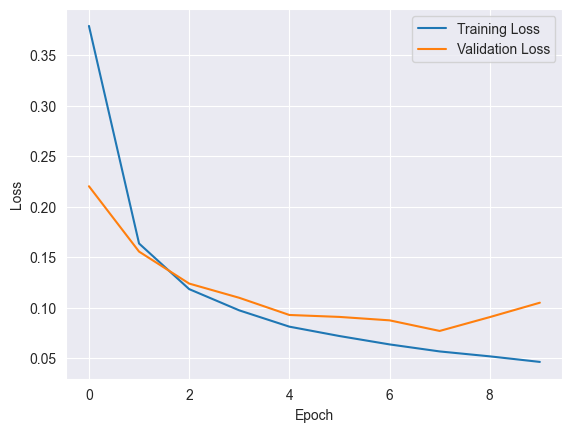

In [12]:
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Using ConvNN

In [17]:
class ConvNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels= 1, out_channels= 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))     # [B, 32, 14, 14]
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
cnn_model = ConvNN()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)

In [18]:
early_stopping = EarlyStopping(patience=5, delta=0.01)

train_loss, val_loss, acc_val = train_val(cnn_model, criterion, optimizer_cnn, train_loader, test_loader, 10)

Epoch 1, Train Loss: 0.1269, Val Loss: 0.0482
Epoch 2, Train Loss: 0.0454, Val Loss: 0.0430
Epoch 3, Train Loss: 0.0355, Val Loss: 0.0379
Epoch 4, Train Loss: 0.0262, Val Loss: 0.0622
Epoch 5, Train Loss: 0.0217, Val Loss: 0.0278
Epoch 6, Train Loss: 0.0173, Val Loss: 0.0341
Epoch 7, Train Loss: 0.0165, Val Loss: 0.0311
Epoch 8, Train Loss: 0.0133, Val Loss: 0.0304
Epoch 9, Train Loss: 0.0100, Val Loss: 0.0462
Epoch 10, Train Loss: 0.0089, Val Loss: 0.0376
Early stopping


In [19]:
acc = np.mean(acc_val)
print(f"Accuracy: {acc:.3f}")

Accuracy: 0.990


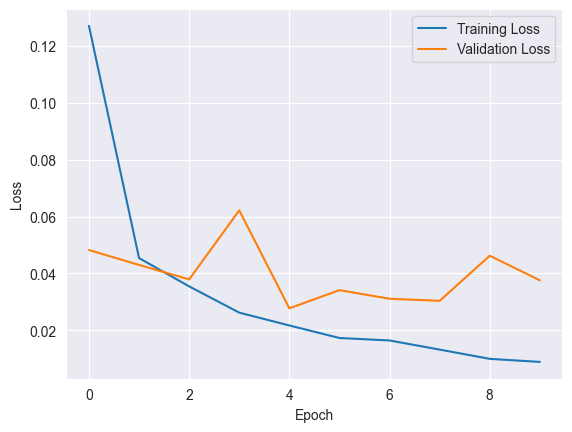

In [20]:
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

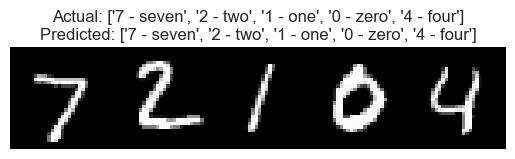

In [26]:
images, labels = next(iter(test_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)

outputs = cnn_model(images)
proba = torch.softmax(outputs, dim=1)

# Берём первые 5
num_images = 5
y_true = labels[:num_images]
y_pred = torch.argmax(proba, dim=1)[:num_images]

# Преобразуем в имена
y_true_name = [names[int(y)] for y in y_true]
y_pred_name = [names[int(y)] for y in y_pred]

# Заголовок
title = f"Actual: {y_true_name}\nPredicted: {y_pred_name}"

# Визуализация
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:num_images].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))
plt.title(title)
plt.axis("off")
plt.show()


In [31]:
from sklearn.metrics import classification_report

predictions = []
real_labels = []

cnn_model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE).float()
        out_class = cnn_model(x)

        preds = torch.argmax(out_class, dim=1)

        predictions.extend(preds.cpu().numpy())
        real_labels.extend(y.cpu().numpy())

# Теперь делаем отчёт
print(classification_report(real_labels, predictions, target_names=names))

              precision    recall  f1-score   support

    0 - zero       0.99      1.00      0.99       980
     1 - one       1.00      0.99      0.99      1135
     2 - two       0.99      0.99      0.99      1032
   3 - three       0.99      0.99      0.99      1010
    4 - four       1.00      0.98      0.99       982
    5 - five       0.98      0.99      0.99       892
     6 - six       1.00      0.99      0.99       958
   7 - seven       0.99      0.99      0.99      1028
   8 - eight       0.98      0.99      0.99       974
    9 - nine       0.97      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

